In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle , Circle
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


In [11]:
import numpy as np

In [12]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

In [13]:
gt = pd.read_csv('results.csv',names=['frame', 'id', 'x1', 'y1', 'x2', 'y2', 'c_r', 'l', 'conf','b'])
 
gt['x'], gt['y'] = ( gt.x1 + gt.x2 ) /2 , (gt.y1 + gt.y2) /2

In [5]:
def transform(xy):

    H = np.array([[ 1.50888127e-03, -5.00588358e-02,  2.74125767e+01],

       [ 1.84526705e-02,  1.13249660e-02, -1.71440251e+01],

       [ 3.69061384e-05,  1.49356499e-03,  1.00000000e+00]])

    z = np.ones((xy.shape[0],1))

    xyz = np.hstack((xy, z))

    trans = H @ xyz.T

    trans[:2] = trans[:2] / trans[2]

    return trans[:2]
 
gt['x'], gt[ 'y'] = transform(gt[['x', 'y']])

In [15]:
unique_ids = gt['id'].unique()[:50]

# Extract the rows corresponding to the first 100 unique IDs
gt = gt[gt['id'].isin(unique_ids)]
gt

,frame,id,x1,y1,x2,y2,c_r,l,conf,b,x,y
0,0,58,-0.14,740.43,66.70,328.73,0.94,-1,-1,-1,33.280,534.580
1,0,213,560.85,163.70,73.47,199.91,0.99,-1,-1,-1,317.160,181.805
2,0,281,793.27,86.01,66.40,175.65,0.97,-1,-1,-1,429.835,130.830
3,0,329,681.41,228.04,81.61,194.28,0.99,-1,-1,-1,381.510,211.160
4,0,331,608.55,220.61,69.00,198.41,0.99,-1,-1,-1,338.775,209.510
...,...,...,...,...,...,...,...,...,...,...,...,...
86545,1871,337,175.08,636.05,62.36,160.62,0.78,-1,-1,-1,118.720,398.335
86614,1872,337,172.97,639.45,66.91,167.28,0.63,-1,-1,-1,119.940,403.365
86684,1873,337,173.50,645.85,63.29,161.12,0.50,-1,-1,-1,118.395,403.485
86751,1874,337,172.47,649.03,63.76,160.57,0.19,-1,-1,-1,118.115,404.800


In [16]:
traj_len = 100  # set length of each trajectory
n_clusters = 10
XTrain = np.zeros((0, traj_len , 2) )  #The array XTrain is designed to eventually hold multiple trajectories, each a sequence of 100 points in 2D space
for i, g in gt.groupby('id'):  # iterates over groups in the DataFrame gt by Id
    traj = g[['x', 'y']].to_numpy()  # for each group(for each id), this line selects the 'x' and 'y' columns and converts them into a NumPy array
    while traj.shape[0] >= traj_len:  # It's used to segment the trajectory into smaller parts if it's longer than traj_len
        XTrain = np.concatenate((XTrain, traj[:traj_len].reshape(1,traj_len , 2)))    #his line takes the first traj_len points from the
                                                                                        #trajectory and reshapes this segment into a 3D array with shape (1, traj_len, 2)
        traj = traj[traj_len:]




XDIFF = XTrain[:, :-1, :] - XTrain[:, 1:, :]
XDIFF = XDIFF.reshape(-1, (traj_len - 1 ) * 2)  # The result of this operation, stored in XDIFF, is a 3D NumPy array where each element [i, j, :] represents the
print(XDIFF)                                        #difference  in the x and y coordinates between the j+1th and jth points of the ith trajectory.

# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(XDIFF))
# print(df_scaled)
# 

[[  0.115   1.135  -2.285 ...   1.28   -3.86   -0.965]
 [ -2.88    3.575   1.67  ...   3.53   -0.055  -3.045]
 [  0.69    0.645   0.57  ...  -2.66   -0.1    -3.06 ]
 ...
 [ -2.24   -0.975  -2.565 ...   2.405   0.545  -0.775]
 [  0.31    1.08    0.095 ...   2.26    0.145  -0.355]
 [  1.125  -6.33   -4.06  ...  16.805   4.525 -26.735]]


In [ ]:
Here before applying DTW normalized the data 

In [17]:
seed = 0
np.random.seed(seed)
# Set the number of clusters
n_clusters = 6
# from tslearn.datasets import CachedDatasets
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# Resampling: Make time series shorter
X_train = TimeSeriesResampler(sz=50).fit_transform(XDIFF)
# Normalization
X_train = TimeSeriesScalerMeanVariance().fit_transform(XDIFF)
# TimeSeriesKMeans with DTW
model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True,metric="dtw")
# training and clustering
y_pred = model.fit_predict(X_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


96.530 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


73.578 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


72.525 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


72.282 --> 72.282 --> 


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


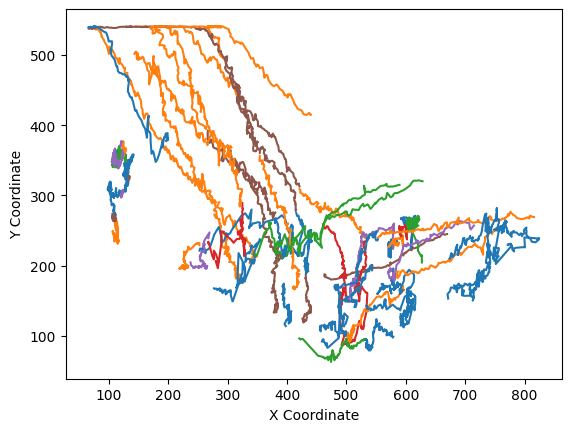

In [20]:
XTrain = XTrain.reshape(-1, traj_len, 2)
for i in range(XTrain.shape[0]):
    plt.plot(XTrain[i, :, 0], XTrain[i, :, 1], c=sns.color_palette()[y_pred[i]])
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

In [19]:
X_train = X_train.reshape(X_train.shape[0], -1)
silhouette_avg = silhouette_score(X_train, y_pred)

# Print the silhouette score
print("The average silhouette score is :", silhouette_avg)

The average silhouette score is : -0.012170568605595724


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]

99.925 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


76.314 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


75.231 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.673 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.465 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.360 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.284 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.255 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.236 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.222 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.190 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.169 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.160 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


74.160 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    0.8s


For n_clusters = 6 the average silhouette_score is : -0.0039371392450404715


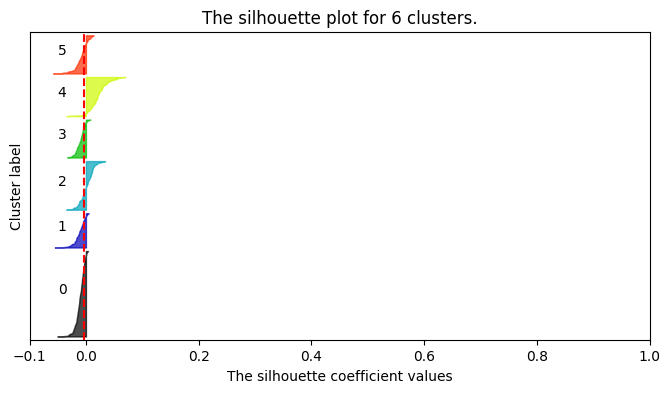

In [9]:
 # Set random seed for reproducibility
np.random.seed(20211231)

# Silhouette analysis for 2, 3, and 4 clusters
cluster_range =[6]

for n_clusters in cluster_range:


    # Create KMeans instance
    model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True,metric="dtw", random_state=20211231)
    # Fit the model
    cluster_labels = model.fit_predict(X_train)

    X_train = X_train.reshape(X_train.shape[0], -1)
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    # print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")
    print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_avg)
    # # Calculate silhouette values for each data point
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

    # # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_train.reshape(X_train.shape[0], -1)) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Fill the silhouette plot
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"The silhouette plot for {n_clusters} clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()


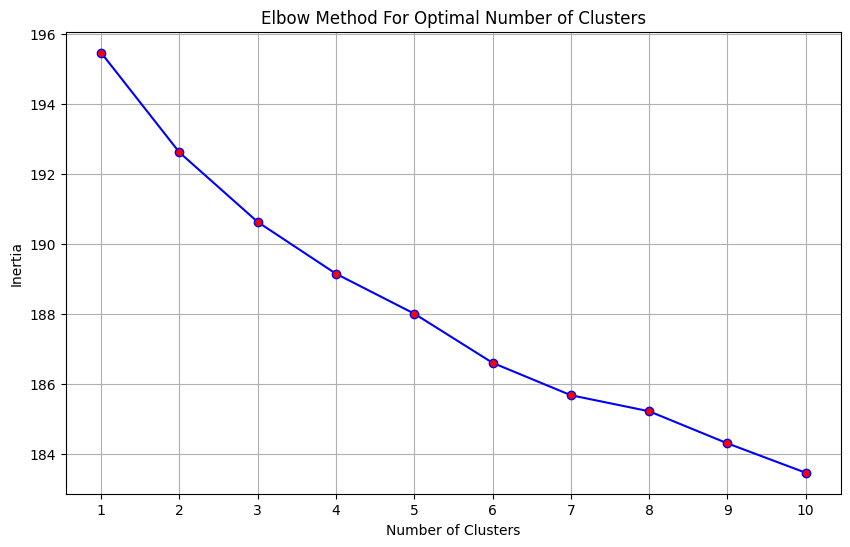

In [16]:
num_clusters = range(1, 11)  # for example, from 1 to 10

inertias = []  # to store the inertia values for different numbers of clusters

for k in num_clusters:
    model = TimeSeriesKMeans(n_clusters=k, random_state=42)  # Create a KMeans instance with k clusters
    y_pred = model.fit_predict(X_train)
    # model.fit(df_scaled)  # Fit the model
    inertias.append(model.inertia_)  # Append the model's inertia to the list

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, inertias, 'bo-', markerfacecolor='red')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(num_clusters)
plt.grid(True)
plt.show()